In [2]:
#import statements

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import os

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.metrics import roc_curve, auc


# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

In [3]:
#get data from patchCAMELYON dataset

def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='input')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='input',
                                             shuffle=False)
     
     return train_gen, val_gen

train_gen, val_gen = get_pcam_generators('C:/Users/20212150/Documents/Year 3/Q3/Project AI mia')
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [5]:
#define autoencoder
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = (96,96,3)
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [6]:
#train autoencoder
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

model_name = 'autoencoder'
weights_filepath = model_name + '_weights.hdf5'
model_filepath = model_name + '.json'



checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


history = autoencoder.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=1,
                    shuffle=True,
                    callbacks=callbacks_list)

  94/4500 [..............................] - ETA: 15:56 - loss: 0.0508

KeyboardInterrupt: 

Text(0.5, 1.0, 'autoencoded image')

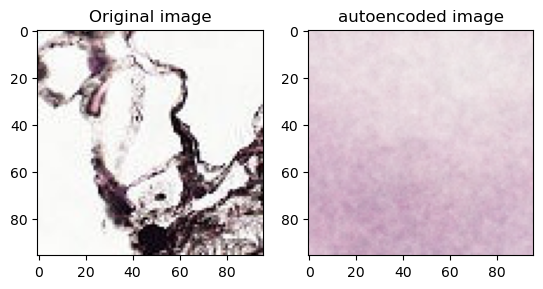

In [6]:
encoded_imgs = autoencoder.encoder(val_gen[1][1]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

fig,ax = plt.subplots(1,2)
ax[0].imshow(val_gen[1][1][1])
ax[1].imshow(decoded_imgs[1])

ax[0].set_title('Original image')
ax[1].set_title('autoencoded image')

In [7]:
#convolutional autoencoder

class CONVautoencoder(Model):
  def __init__(self):
    super(CONVautoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(96, 96, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
 
autoencoder = CONVautoencoder()

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


model_name = 'CONVautoencoder'
weights_filepath = model_name + '_weights.hdf5'
model_filepath = model_name + '.json'



checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


history = autoencoder.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=1,
                    shuffle=True,
                    callbacks=callbacks_list)

4500/4500 [==============================] - ETA: 0s - loss: 0.0099
Epoch 1: val_loss improved from inf to 0.00681, saving model to CONVautoencoder_weights.hdf5


c:\Users\20212150\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

Text(0.5, 1.0, 'autoencoded image')

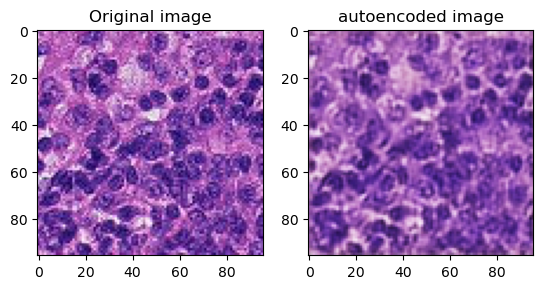

In [9]:
encoded_imgs = autoencoder.encoder(val_gen[1][1]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

fig,ax = plt.subplots(1,2)
ax[0].imshow(val_gen[1][1][2])
ax[1].imshow(decoded_imgs[2])

ax[0].set_title('Original image')
ax[1].set_title('autoencoded image')